 # SNLI Shortcut analysis

In [1]:
import sys, pandas as pd, os, matplotlib.pyplot as plt, sklearn
from sklearn import tree
from pyirr import kappa2

sys.path.append("../src")
from utils.s3_utils import download_file as download_file_s3



In [2]:
temp_dir = "temp"

In [3]:
s3_file_test_predictions = "s3://aegovan-data/model_predictions/snli-evaluate-20240322215932/snli_1.0_test_predictions.json"

In [4]:
s3_file_train = "s3://aegovan-data/nli/snli/snli_1.0_train.jsonl"

## Run 

In [5]:
test_predictions_file = download_file_s3(s3_file_test_predictions, temp_dir)
train_file = download_file_s3(s3_file_train, temp_dir)

In [6]:
test_predictions_file = os.path.join(temp_dir,"snli_1.0_test_predictions.json" )
train_file = os.path.join(temp_dir,"snli_1.0_train.jsonl" )

In [7]:
import json
def load_json(json_file):
    df = pd.read_json(json_file, orient="records")
    return df

def load_jsonl(jsonl_file):
    records = []
    with open(jsonl_file) as f:
        for l in f:
            records.append(json.loads(l))
        
    df = pd.DataFrame(records)
    return df

def add_x_y(df, x_column, y_column):
    df["x"] = df[x_column]
    df["y"] = df[y_column]
    return df

def rename_columns(df):
    cols = {
        "sentence1" : "premise",
        "sentence2" : "hypothesis",
        "gold_label" : "label"
     }
    df = df.rename(columns =cols )
    return df
def filter_empty_label(df):
    
    df = df[~df["label"].isin(["-"])].copy()
    return df

def add_join_hyp_premise(df):
    df["prem_hyp"] = df.apply(lambda x: "{}. {}".format(x["premise"], x["hypothesis"]), axis=1)
    return df

In [8]:
from model_nb_nli_classifier import ModelNBNliClassifier
from model_nb_tree_nli_classifier import ModelNBTreeNliClassifier


NAIVE_BAYES="Naive Bayes"
NAIVE_BAYES_WITH_TREE = "Naive Bayes + Tree"


def add_x_json_column(df):
    df["x_json"] = df.apply(lambda r: {"premise" : r["premise"] ,
                                       "hypothesis" : r["hypothesis"] ,
                                       "prem_hyp" : r["prem_hyp"]
                                      },
                            axis=1)
    
    return df

def  train_and_predict_all_classifiers(df, x_column, min_df=None, ngram_range=(1,1), stop_words = 'english', classifiers={NAIVE_BAYES, NAIVE_BAYES_WITH_TREE}, max_words_per_class = 200, classwise_vocab=True):
    
    max_tree_depth = 4
    
    df = df.copy().pipe(add_x_json_column)
    
   
    
    classifiers_map = {
        NAIVE_BAYES : {"model" : ModelNBNliClassifier( min_df=min_df, 
                                            max_words_per_class=max_words_per_class, 
                                            stop_words=stop_words, 
                                            ngram_range=ngram_range, 
                                            classwise_vocab=classwise_vocab),
                       "x" : "x"
                      },
        
        NAIVE_BAYES_WITH_TREE: { "model" : ModelNBTreeNliClassifier(x_feature_key=x_column, min_df=min_df, 
                                                                    max_words_per_class=max_words_per_class, 
                                                                    stop_words=stop_words, 
                                                                    ngram_range=ngram_range, 
                                                                    classwise_vocab=classwise_vocab,
                                                                    max_tree_depth = max_tree_depth),
                                
                                "x" : "x_json"
                                
                               }
    }
   
    
    result = {}
    
    for k in filter(lambda x: x in classifiers,  classifiers_map):
    
        m = classifiers_map[k]["model"]
        x_col = classifiers_map[k]["x"]
        
        print(f"Training {k}")
        
        m.train(df[x_col], df["y"])
        p, p_conf = m.predict(df[x_col])
        result[k] = {
            "m" : m,
            f"predictions" : p,
            f"predictions_conf": p_conf
        }
    return result



def  predict_all_classifiers(df, models_dict):
    
    
    result = {}
    for k, v in models_dict.items():
        m = v["m"]
        
        p, p_conf = m.predict(df["x"])
        result[k] = {
            "m" : m,
            "predictions" : p,
            "predictions_conf": p_conf
        }
    return result


In [9]:
def isint(a):
    try:
        t = int(a)
        return True
    except:
        return False
    
def float_percent_format(x):
     return "{:.1f}".format(x*100)

    
def float_format(x):
     return "{:.2f}".format(x)

def int_format(x):
     return str(int(x))
    
def compute_kappa(r1, r2):
    python_kappa = sklearn.metrics.cohen_kappa_score(r1,r2)
    print(python_kappa)
    data = {'r1': r1,
        'r2': r2}

    df = pd.DataFrame(data)
    r_kappa = kappa2(df, weight="unweighted")
    print(r_kappa)
    
    result = {
        "python_kappa" : python_kappa,
        "r_kappa" : r_kappa.value,
        "r_pvalue":r_kappa.pvalue
        
    }
    return result
    
     

def print_report(actual, pred, labels=None, label_names=[]):
      
    d = sklearn.metrics.classification_report(actual,
                                            pred,
                                            output_dict=True,
                                            zero_division=0)
    # Compute K
    k_scores = compute_kappa(actual, pred )
    for k, v in k_scores.items():
        d[k] = {
            "cohen" : v,
            "support" : len(actual),

        }
    df =  pd.DataFrame(d).T
    df.insert(1, "index", df.index)


    return df
    
def print_report_all_classifiers(actual,  results_dict, *args, **kwargs):
    result = []
    for k, v in results_dict.items():
        df = print_report(actual,v["predictions"],  *args, **kwargs)
        df.insert (0, "model", k)
        
        result.append(df)
    df = pd.concat(result)
    print(df.to_latex(index=False, formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format }))
    return df
        
        

In [10]:

def plot_tree(m, figname):
    _, ax = plt.subplots(1,1, figsize=(45,15))

    tree.plot_tree(m.tree_model, ax=ax, fontsize=10, feature_names=m.feature_names, filled=True, rounded=True)
    
    plt.savefig(figname)
    plt.show()
    



In [11]:
# from dtreeviz.trees import *
# def plot_tree_pretty(m, x, y,  title="", image_save_path=None):
#     import sys
#     dot_path = '/opt/homebrew/bin/'
#     if dot_path not in sys.path :
#         sys.path.append( dot_path)
#         for p in sys.path:
#             os.environ["PATH"] = os.environ.get("PATH","") + ":" +  p

#     viz = dtreeviz(m.tree_model,
#                x_data=m.extract_features(m.preprocess(x)),
#                y_data=y,
#               # target_name=target_name,
#                feature_names=m.feature_names,
#                class_names=label_names,
#                title=title)
    
#     # tree_plt.view()    
#     if image_save_path:
#         viz.save(image_save_path)
        
#     return viz



In [12]:
def get_top_discrimintary_keywords(model, label_index ) :
    index_to_vocab = {i:v  for v,i in model.vocab.items()}
    
    #. ( [ (index_to_vocab[i],p) for i,p in enumerate(model.nb_model.feature_log_prob_[label_index])]

    return sorted( [ (index_to_vocab[i],p) for i,p in enumerate(model.nb_model.feature_log_prob_[label_index])], 
           reverse=True, key=lambda x: x[1])[:50]




In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def consolidate_label_names(actual, pred, label_names):
    label_indices = list(set(actual).union(pred))
    return [label_names[i] for i in sorted(label_indices)]

def plot_confusionmatrix(y_true,y_pred):
    cm = confusion_matrix(y_true,y_pred)
    labels = consolidate_label_names( y_true,y_pred,label_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
    disp.plot(cmap="PuBu", xticks_rotation="vertical")
    

In [14]:
def run_analysis(df, x_column,y_column, meta_dataset, meta_target):
    df = df.copy(deep=True).pipe(add_x_y, x_column=x_column, y_column=y_column)
    result = train_and_predict_all_classifiers(df,x_column, min_df=1)
    
    all_labels = list(df["label"].unique())
    
    df_report = print_report_all_classifiers(df[y_column], result,  all_labels)
    #get_top_discrimintary_keywords(result[NAIVE_BAYES]["m"],0)
    summary_rec = {"df": df,
                   "df_report" :df_report,
                   "model_result" : result,
                   "meta":[
                       { "name": "dataset" , "value": meta_dataset},
                       { "name": "T" , "value": meta_target}
                          ]
                  }


    return  summary_rec
    


In [15]:
all_results = []

## Train GT Train predictions

In [16]:
df_train = load_jsonl(train_file).pipe(rename_columns)\
                                .pipe(filter_empty_label)\
                                .pipe(add_join_hyp_premise)

r=run_analysis(df_train, x_column="premise", y_column="label", meta_dataset="SNLI TR PRM", meta_target="GT")
all_results.append(r)

r=run_analysis(df_train, x_column="hypothesis", y_column="label", meta_dataset="SNLI TR HYP", meta_target="GT")
all_results.append(r)

r = run_analysis(df_train, x_column="prem_hyp", y_column="label", meta_dataset="SNLI TR", meta_target="GT")
all_results.append(r)




Training Naive Bayes
Max words :  202
Training Naive Bayes + Tree
Max words :  202
Extracting features..for 549367
Completed..
0.0017259533996771825
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 549367
  Raters = 2
   Kappa = 0.002

       z = 1.838
 p-value = 0.066

0.1868820705195724
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 549367
  Raters = 2
   Kappa = 0.187

       z = 196.367
 p-value = 0.000

\begin{tabular}{lrlrrrr}
\toprule
             model & precision &         index & recall & f1-score & support &    cohen \\
\midrule
       Naive Bayes &      33.4 & contradiction &   28.0 &     30.5 &  183187 &      NaN \\
       Naive Bayes &      33.5 &    entailment &   45.4 &     38.5 &  183416 &      NaN \\
       Naive Bayes &      33.4 &       neutral &   27.0 &     29.9 &  182764 &      NaN \\
       Naive Bayes &      33.5 &      accuracy &   33.5 &     33.5 &       0 & 0.334583 \\
       Naive Bayes &      33.5 &     macro avg &   33.4 &     

## Test 

### Predict Test on Test GT fit

In [17]:
df_test = load_json(test_predictions_file).pipe(add_join_hyp_premise)

r=run_analysis(df_test, x_column="premise", y_column="label", meta_dataset="SNLI TS PRM", meta_target="GT")
all_results.append(r)

r=run_analysis(df_test, x_column="hypothesis", y_column="label", meta_dataset="SNLI TS HYP", meta_target="GT")
all_results.append(r)

r = run_analysis(df_test, x_column="prem_hyp", y_column="label", meta_dataset="SNLI TS", meta_target="GT")
all_results.append(r)





Training Naive Bayes
Max words :  215
Training Naive Bayes + Tree
Max words :  215
Extracting features..for 9824
Completed..
0.03686705214146879
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 9824
  Raters = 2
   Kappa = 0.037

       z = 5.278
 p-value = 0.000

0.20251365713223668
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 9824
  Raters = 2
   Kappa = 0.203

       z = 28.659
 p-value = 0.000

\begin{tabular}{lrlrrrr}
\toprule
             model & precision &         index & recall & f1-score & support &        cohen \\
\midrule
       Naive Bayes &      35.6 & contradiction &   22.2 &     27.4 &    3237 &          NaN \\
       Naive Bayes &      36.1 &    entailment &   48.3 &     41.3 &    3368 &          NaN \\
       Naive Bayes &      36.0 &       neutral &   36.8 &     36.4 &    3219 &          NaN \\
       Naive Bayes &      36.0 &      accuracy &   36.0 &     36.0 &       0 & 3.595277e-01 \\
       Naive Bayes &      35.9 &     macro avg &  

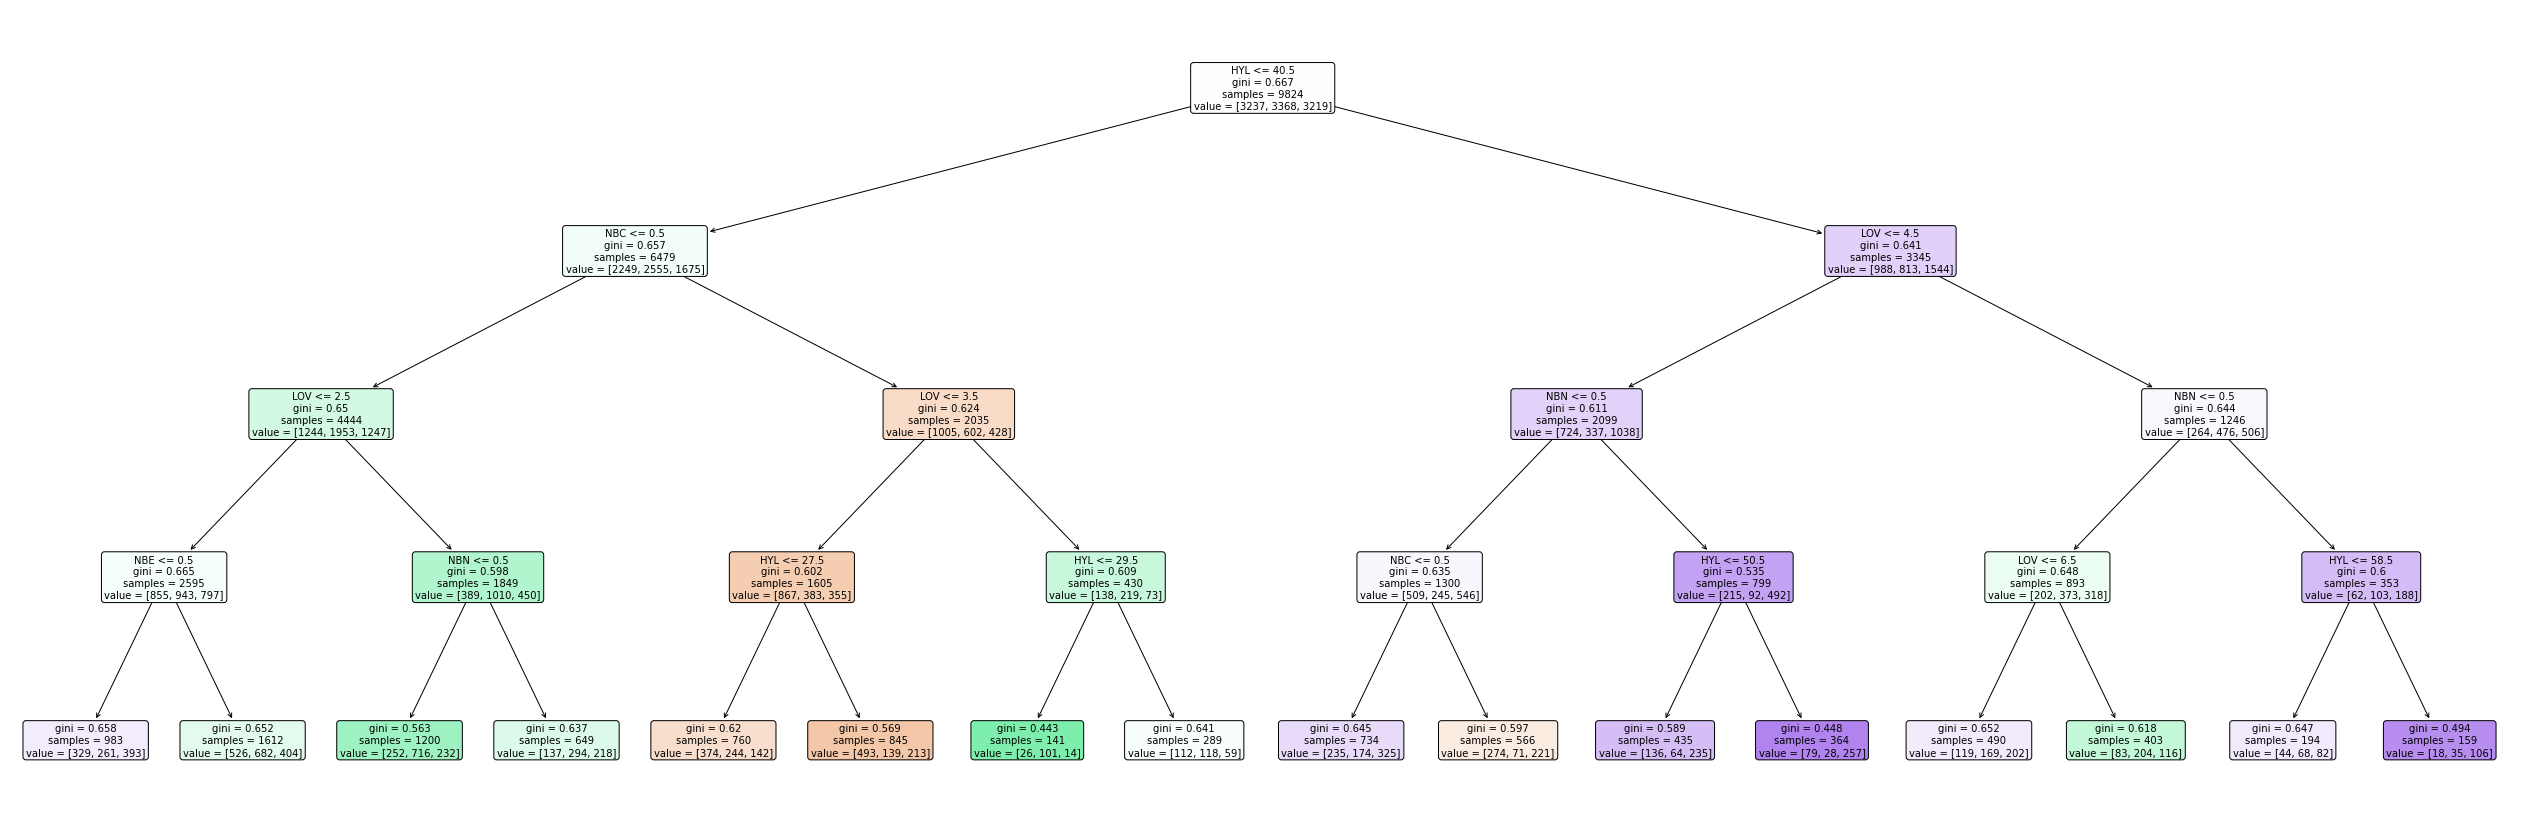

In [18]:
plot_tree(r["model_result"][NAIVE_BAYES_WITH_TREE]["m"], "test_gt_fit_prem_hyp.pdf")

In [19]:
r=run_analysis(df_test, x_column="premise", y_column="predicted_label", meta_dataset="SNLI TS PRM", meta_target="BP")
all_results.append(r)

r=run_analysis(df_test, x_column="hypothesis", y_column="predicted_label", meta_dataset="SNLI TS HYP", meta_target="BP")
all_results.append(r)

r=run_analysis(df_test, x_column="prem_hyp", y_column="predicted_label", meta_dataset="SNLI TS", meta_target="BP")
all_results.append(r)

Training Naive Bayes
Max words :  221
Training Naive Bayes + Tree
Max words :  221
Extracting features..for 9824
Completed..
0.04975656871388545
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 9824
  Raters = 2
   Kappa = 0.050

       z = 7.151
 p-value = 0.000

0.19855105427313902
 Cohen's Kappa for 2 Raters (Weights: unweighted) 
Subjects = 9824
  Raters = 2
   Kappa = 0.199

       z = 28.817
 p-value = 0.000

\begin{tabular}{lrlrrrr}
\toprule
             model & precision &         index & recall & f1-score & support &        cohen \\
\midrule
       Naive Bayes &      36.6 & contradiction &   23.5 &     28.6 &    3192 &          NaN \\
       Naive Bayes &      36.6 &    entailment &   33.8 &     35.2 &    3270 &          NaN \\
       Naive Bayes &      37.2 &       neutral &   52.6 &     43.6 &    3362 &          NaN \\
       Naive Bayes &      36.9 &      accuracy &   36.9 &     36.9 &       0 & 3.687907e-01 \\
       Naive Bayes &      36.8 &     macro avg &  

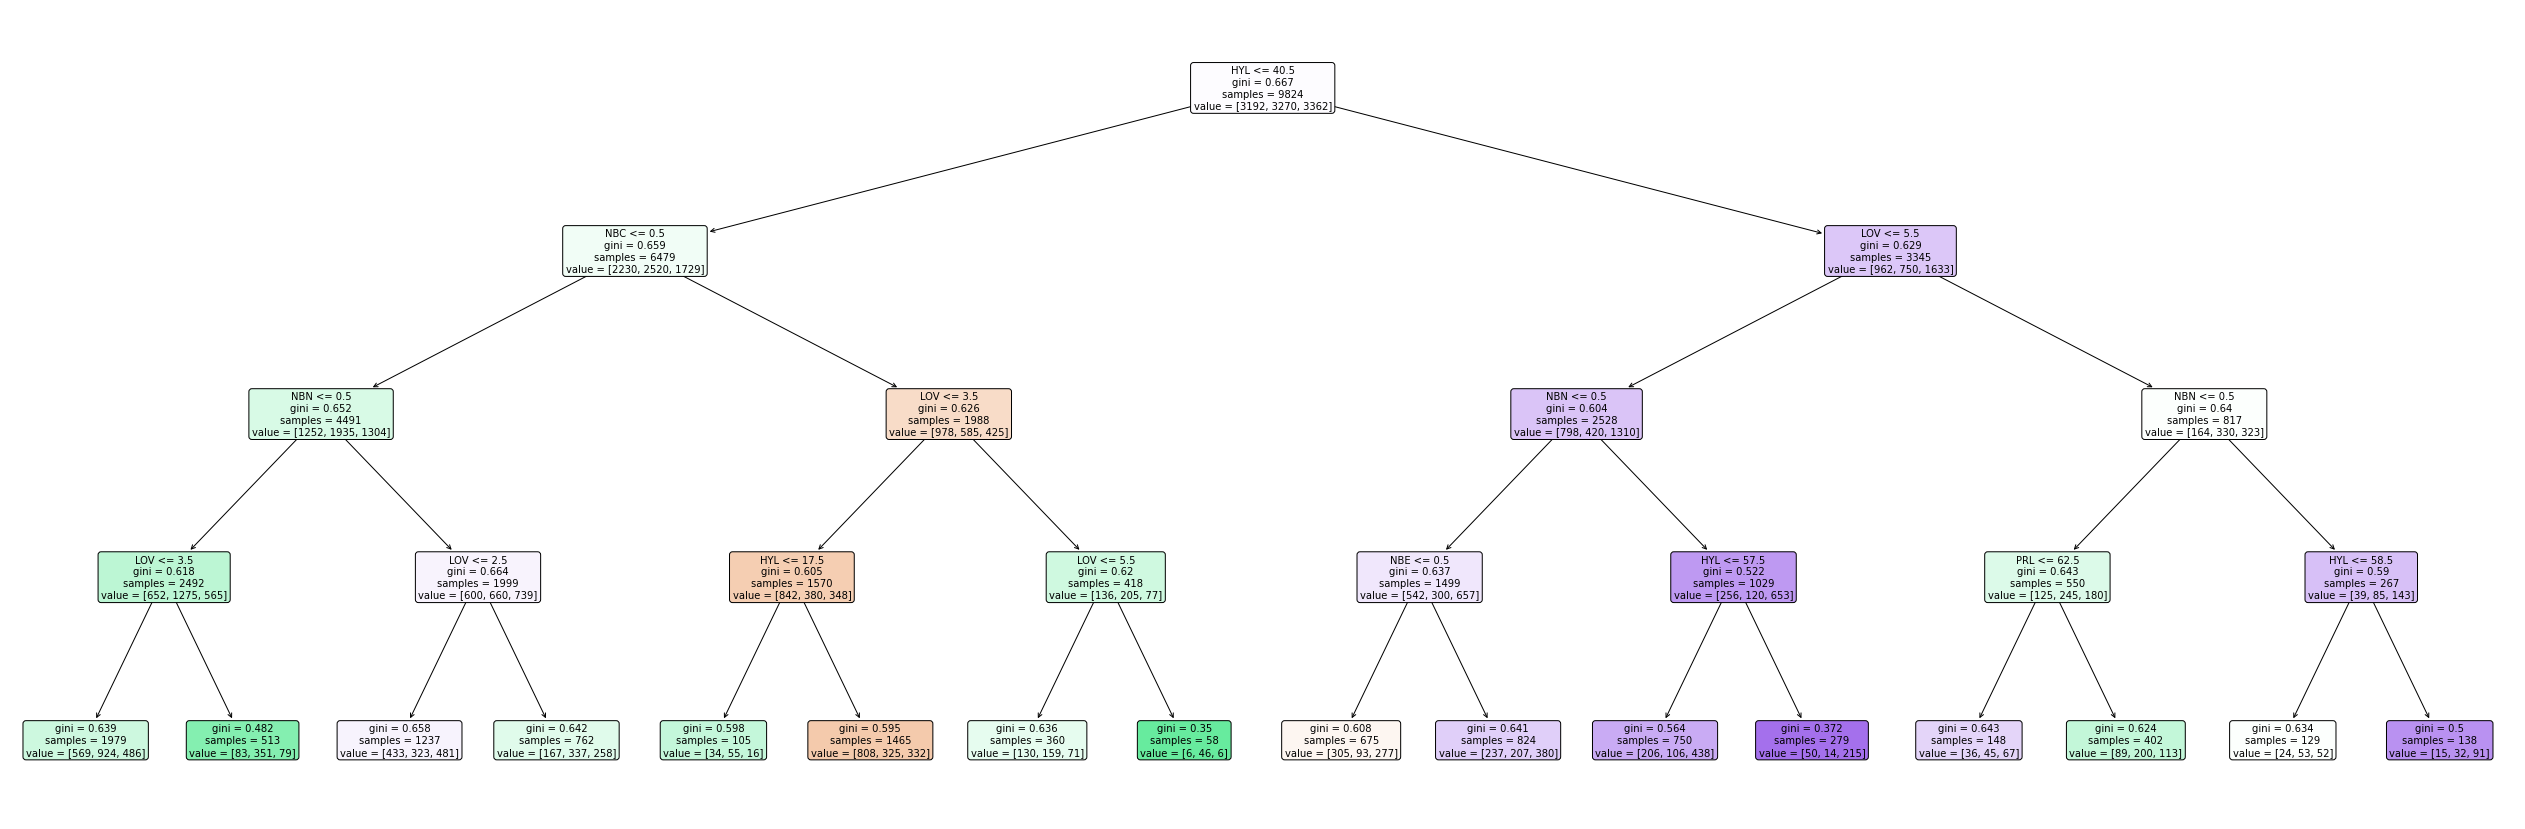

In [20]:
plot_tree(r["model_result"][NAIVE_BAYES_WITH_TREE]["m"], "test_bp_fit_prem_hyp.pdf")

In [21]:
# plot_tree(result_test_bp[NAIVE_BAYES_WITH_TREE]["m"])
# plot_tree_pretty(r_test_predicted_label[NAIVE_BAYES_WITH_TREE]["m"], 
#                  df_test.pipe(add_x_json_column)["x_json"], 
#                  df_test["predicted_label"], "Test prediction fit", "test_prediction_treeplot.svg")

## Latex results

In [22]:
def prepare_latex(meta_dict_df, index_filter=None ):#["micro avg"]
    result = []
    model_names = {NAIVE_BAYES: "NB",
                  NAIVE_BAYES_WITH_TREE:"NBT"
    }

    for item in meta_dict_df:
        df= item["df_report"].copy(deep=True)
        if index_filter:
            df = df[df["index"].isin(index_filter)].copy(deep=True)
        df["model"] = df["model"].apply(lambda x: model_names[x])
        for i, meta in enumerate(item["meta"]):
            df.insert(i, meta["name"], meta["value"])
        result.append(df)
    df_summ = pd.concat(result)
    
    # Drop index if just one ..
    if df["index"].nunique() ==1:
        df_summ = df_summ.drop("index", axis=1)
    
    return df_summ
    


df_summ = prepare_latex (all_results, index_filter = ["python_kappa", "r_kappa", "r_pvalue"] )

print(df_summ.to_latex(index=False, formatters = {"precision": float_percent_format,
                                                  "recall":float_percent_format, 
                                                  "f1-score":float_percent_format,
                                                  "support":int_format,
                                                 "cohen":float_format}))

\begin{tabular}{lllrlrrrr}
\toprule
    dataset &  T & model & precision &        index & recall & f1-score & support & cohen \\
\midrule
SNLI TR PRM & GT &    NB &       NaN & python\_kappa &    NaN &      NaN &  549367 &  0.00 \\
SNLI TR PRM & GT &    NB &       NaN &      r\_kappa &    NaN &      NaN &  549367 &  0.00 \\
SNLI TR PRM & GT &    NB &       NaN &     r\_pvalue &    NaN &      NaN &  549367 &  0.07 \\
SNLI TR PRM & GT &   NBT &       NaN & python\_kappa &    NaN &      NaN &  549367 &  0.19 \\
SNLI TR PRM & GT &   NBT &       NaN &      r\_kappa &    NaN &      NaN &  549367 &  0.19 \\
SNLI TR PRM & GT &   NBT &       NaN &     r\_pvalue &    NaN &      NaN &  549367 &  0.00 \\
SNLI TR HYP & GT &    NB &       NaN & python\_kappa &    NaN &      NaN &  549367 &  0.25 \\
SNLI TR HYP & GT &    NB &       NaN &      r\_kappa &    NaN &      NaN &  549367 &  0.25 \\
SNLI TR HYP & GT &    NB &       NaN &     r\_pvalue &    NaN &      NaN &  549367 &  0.00 \\
SNLI TR HYP & GT